# Figure 4

In [1]:
import os 
import numpy as np
import pandas as pd
import scipy.optimize as op
from copy import deepcopy

from astropy.time import Time
from astropy.table import Table
import astropy.constants as const
from astropy.io import fits
import astropy.io.ascii as asci

import astropy.constants as const

from scipy.optimize import fmin
from scipy.spatial.distance import cdist
from numpy.linalg import inv
from numpy.linalg import slogdet
from numpy.random import multivariate_normal

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)


import matplotlib
import matplotlib.pyplot as plt
fs = 10
matplotlib.rcParams['font.size']=fs
ms = 6
matplotlib.rcParams['lines.markersize']=ms


t0 = 59012.0
z = 0.1353

In [16]:
def add_GP(ax, tbsrg, do_press = False):
    x1 = tbsrg["phase"].data
    if do_press:
        x1 = tbsrg["days_press"].data
    y1 = tbsrg["RATE"].data
    ey1 = tbsrg["rate_unc"].data
    multi = 10
    #gaus_unc = "default"
    ngaus = 100
    x = np.linspace(min(x1)-3, max(x1)+3, ngaus)
    p0 = [1.0,1.0]
    p1 = fmin(NLL_GP, p0, args=(kernel_Mat32, x1, y1*multi, ey1*multi))
    print ("Best paramter: A = %.2f, l = %.2f"%(10**(p1[0]), 10**(p1[1])))
    m,C=Pred_GP(kernel_Mat32,p1,x1,y1*multi,ey1*multi,x)
    sig = np.sqrt(np.diag(C))
    samples = multivariate_normal(m,C,5)
    color = "darkorange"
    ax.plot(x, m/multi,'-', linewidth = 0.8, color = color, zorder = 3, label = "model fit")
    ax.fill_between(x, m/multi+sig/multi, m/multi-sig/multi, color=color,alpha=0.2, zorder = 3, 
                    label = r"1$\sigma$"+" confidence") #1-sigma confidence


def Pred_GP(CovFunc, CovPar, xobs, yobs, eobs, xtest):
    # evaluate the covariance matrix for pairs of observed inputs
    K = CovFunc(CovPar, xobs, xobs) 
    # add white noise
    K += np.identity(xobs.shape[0]) * eobs**2
    # evaluate the covariance matrix for pairs of test inputs
    Kss = CovFunc(CovPar, xtest, xtest)
    # evaluate the cross-term
    Ks = CovFunc(CovPar, xtest, xobs)
    # invert K
    Ki = inv(K)
    # evaluate the predictive mean
    m = np.dot(Ks, np.dot(Ki, yobs))
    # evaluate the covariance
    cov = Kss - np.dot(Ks, np.dot(Ki, Ks.T))
    return m, cov

    
    
def kernel_Mat32(par, x1, x2):
    """
    Mat: the Matern class of covariance functions
    whith nu = 3/2
    See Eq. (4.17) of book RW+2006
    """
    p0 = 10.0**par[0]
    p1 = 10.0**par[1]
    DD = cdist(x1.reshape(len(x1),1), x2.reshape(len(x2),1), 'euclidean')
    arg = np.sqrt(3) * abs(DD) / p1
    return p0 * (1 + arg) * np.exp(- arg)

    
def NLL_GP(p,CovFunc,x,y,e):
    # Evaluate the covariance matrix
    K = CovFunc(p,x,x)
    # Add the white noise term
    K += np.identity(x.shape[0]) * e**2
    # invert it
    Ki = inv(K)
    # evaluate each of the three terms in the NLL
    term1 = 0.5 * np.dot(y,np.dot(Ki,y))
    term2 = 0.5 * slogdet(K)[1]
    term3 = 0.5 * len(y) * np.log(2*np.pi)
    # return the total
    return term1 + term2 + term3


In [7]:
def get_tbsrg():
    filename = "../data/data_20mrf/srg/src_2485_020_LightCurve_00001_e2.fits"
    header = fits.open(filename)[1].header
    tstart = header["TSTART"] # Start time of exposure in TIMESYS sy
    tstop = header["TSTOP"] # End time of exposure in TIMESYS syst
    tdur_d = (tstop - tstart) / 24/3600
    print ("%.2f days"%(tdur_d))
    
    datestart = header["DATE-OBS"] # UTC Start time of expo
    mjdstart = Time(datestart).mjd
    datestop = header["DATE-END"] # UTC End time of exposu
    mjdstop = Time(datestop).mjd
    tdur_mjd = mjdstop - mjdstart
    print (datestart, datestop, "%.2f days"%tdur_mjd)
    
    mjdref = header["MJDREF"] # MJD at TIMEZERO    
    
    # Yuhan: I'm totally confused....        
    
    tbsrg = Table(fits.open(filename)[1].data)
    tbsrg = tbsrg[np.argsort(tbsrg["TIME"])]
    print ("%.2f days"%((tbsrg["TIME"].data[-1] - tbsrg["TIME"].data[0])/24/3600))
    
    mjd = mjdref + tbsrg["TIME"].data / 3600 / 24
    
    phase = (mjd - t0) / (1+z)
    days_press = mjd - Time("2020-07-21T00:00:00").mjd
    
    tbsrg.remove_column("TIME")
    tbsrg["phase"] = phase
    tbsrg["days_press"] = days_press
    
    # remove the first two datapoints and the last...?
    
    c = tbsrg['COUNTS'].data
    bc = tbsrg['BACK_COUNTS'].data
    timedel = tbsrg["TIMEDEL"].data
    bgratio = tbsrg['BACKRATIO'].data
    fractime = tbsrg['FRACTIME'].data
    sigma_src = (c + 0.75)**0.5 + 1
    sigma_bkg = (bc + 0.75)**0.5 + 1
    rate_err = (sigma_src**2 + sigma_bkg**2 * bgratio)**0.5 / (timedel * fractime)
    
    tbsrg["rate_unc"] = rate_err
    tbsrg["MJD"] = mjd
    
    return tbsrg

In [8]:
def plot_e2lc(tbsrg):
    ymin = -0.18
    ymax = 0.58
    xmin = 34.4
    xmax = 37.7
    
    yerrcol  = "rate_unc"
    
    plt.figure(figsize = (4.8, 3.0))
    ax = plt.subplot(111)
    ax.errorbar(tbsrg["phase"], tbsrg["RATE"], tbsrg[yerrcol], fmt = ".k", linewidth = 0.8,
                marker = "o", markersize = ms-2, zorder = 10, label = "data")
    ax.set_ylabel("Rate in 0.2--2.2 keV ("+r"$\rm count\,s^{-1}$"+")")
    ax.set_xlabel("$\Delta t$"+" (days)")
    
    ax.tick_params(which = 'major', length = 4, top=False, direction = "in", right = False)
    ax.tick_params(which = 'minor', length = 2, top=False, direction = "in", right = False)
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.02))
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
    
    print ("Uncomment this function if you want to divide the data into three chucks...")
    # add_average(ax, tbsrg)
    print ("But let's just do a Gaussian regression...")
    add_GP(ax, tbsrg)
    
    ax.legend(loc = "upper left")
    
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    plt.tight_layout(rect =(-0.03, -0.05, 1.02, 1.02))
    

4.50 days
2020-07-13T20:59:48 2020-08-03T13:00:14 20.67 days
3.33 days
Uncomment this function if you want to divide the data into three chucks...
But let's just do a Gaussian regression...
Optimization terminated successfully.
         Current function value: 32.360026
         Iterations: 50
         Function evaluations: 94
Best paramter: A = 2.42, l = 0.65


/var/folders/51/8dbdmtw12rn86njf20zwrsc80000gn/T/ipykernel_51049/1070202569.py:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".k" (-> marker='.'). The keyword argument will take precedence.
  ax.errorbar(tbsrg["phase"], tbsrg["RATE"], tbsrg[yerrcol], fmt = ".k", linewidth = 0.8,


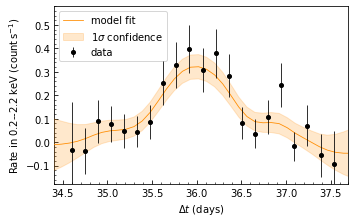

In [17]:
    tbsrg = get_tbsrg()
    plot_e2lc(tbsrg)